# A look into Real Estate trends in Ireland. 

## Goal of the Analysis and Business questions

The analysis will use the open source data set that can be found IE Registry website (https://www.propertypriceregister.ie/). We assume the perspective of an investor that is willing to bet in the Real Estate Irish market. We want to provide insights to make sure that we drive the investments where it makes more sense, i.e. we have the best ReturnOnInvestment (ROI). 

These are the questions we want to answer: 

1. Where do we want to invest first? Practically, it would be useful to have a stack rank of regions where we could potentially have the highest ROIs
2. Is this the right moment to invest? Practically, use the historical data to have a simple forecast for the next 6-12 months of the region we believe is worth investing
3. What is the most relevant type of real estate we should be focusing on? Practically, we want to evaluate wether it makes sense to invest in condos or single house units, etc. 

## Structure of the Notebook
1. Import libraries and load the data
2. Clean up and manipulate the data
3. Exploration and visualization. First level of Insights
4. Model training and testing. Secon level of Inisghts
5. Wrap-up



## 1. Import libraries and load the data

In [1]:
# data manipulation and cleaning
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import datetime
from functools import reduce



# visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import csv
raw = pd.read_csv('historical_data_registry.csv')

# create a copy for manipulation
df = raw.copy()

## 2. Data cleaning

In [3]:
# basic dataframe evaluation
print(df.info()); print(df.shape); print(df.describe()); df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410523 entries, 0 to 410522
Data columns (total 10 columns):
id                           410523 non-null int64
Date of Sale (dd/mm/yyyy)    410523 non-null object
Address                      410523 non-null object
Postal Code                  76876 non-null object
County                       410523 non-null object
Price                        410523 non-null object
Not Full Market Price        410523 non-null object
VAT Exclusive                410523 non-null object
Description of Property      410523 non-null object
Property Size Description    52567 non-null object
dtypes: int64(1), object(9)
memory usage: 31.3+ MB
None
(410523, 10)
                  id
count  410523.000000
mean   205329.797042
std    118744.625993
min         1.000000
25%    102631.500000
50%    205262.000000
75%    307892.500000
max    900559.000000


,id,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price,Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,1,01/01/2010,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,2,03/01/2010,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
2,11,04/01/2010,"16 Aisling Geal, Fr. Russell Road",NaN,Limerick,"110,000.00",No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...
3,21,04/01/2010,"48 KILLIANS COURT, MULLAGH",NaN,Cavan,"122,000.00",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres
4,35,04/01/2010,"Knock, Lanesboro",NaN,Longford,"125,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


First thing I want to do some manipulation to the column names and index: 

- The date column is not in the right format, this can create problems during analysis. We change it to the right format
- We set the index to the date column to make it easier to create charts and analyze later
- We add an additional column to reflect the month and the year of the date. This will facilitate time series aggregation later on
- We change the column names to reflect the pep8 format



In [4]:
# Prepare dict names and modify the headers in the dataframe and rename columns
columns = {
    'id' : 'id', 
    'Date of Sale (dd/mm/yyyy)': 'date_of_sale', 
    'Address': 'address', 
    'Postal Code' : 'postal_code', 
    'County' : 'county',
    'Price' : 'price', 
    'Not Full Market Price' : 'not_full_market_price', 
    'VAT Exclusive' : 'vat_exclusive',
    'Description of Property' : 'property_description', 
    'Property Size Description' : 'property_size'
}

df = df.rename(columns = columns)

# change to datetime format and set date as index
df['date_of_sale'] = pd.to_datetime(df['date_of_sale'])

# add the month-year date column. we use the end of the month as time anchor 
df['month_year'] = pd.to_datetime(df['date_of_sale'], format="%Y%m") + MonthEnd(0)




In [5]:
df.head()

,id,date_of_sale,address,postal_code,county,price,not_full_market_price,vat_exclusive,property_description,property_size,month_year
0,1,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,Dublin,"343,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN,2010-01-31
1,2,2010-03-01,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,Laois,"185,000.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2010-03-31
2,11,2010-04-01,"16 Aisling Geal, Fr. Russell Road",NaN,Limerick,"110,000.00",No,No,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2010-04-30
3,21,2010-04-01,"48 KILLIANS COURT, MULLAGH",NaN,Cavan,"122,000.00",No,Yes,New Dwelling house /Apartment,greater than 125 sq metres,2010-04-30
4,35,2010-04-01,"Knock, Lanesboro",NaN,Longford,"125,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN,2010-04-30


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410523 entries, 0 to 410522
Data columns (total 11 columns):
id                       410523 non-null int64
date_of_sale             410523 non-null datetime64[ns]
address                  410523 non-null object
postal_code              76876 non-null object
county                   410523 non-null object
price                    410523 non-null object
not_full_market_price    410523 non-null object
vat_exclusive            410523 non-null object
property_description     410523 non-null object
property_size            52567 non-null object
month_year               410523 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 34.5+ MB


By exploring the data set further, we see that we have additional data cleaning to do: 

- Transform the price data type to float
- Transform vat_exclusive and not_full_market_price to boolean values
- handle strings in address and property_description
- handle NaN values in postal_code and property_size


In [7]:
# Convert data types to correct dtype
df.price = df.price.str.replace(',', '').astype(float)



In [8]:
# we convert address to split into multiple variables with structure address line 1, line 2 and line 3
df[['address_1', 'address_2', 'address_3']] = df.address.str.split(', ', expand=True)



In [9]:
# transforming vat_exclusive and not_full_market_price to boolean
df['vat_exclusive'] = df['vat_exclusive'] == 'Yes'

df['not_full_market_price'] = df['not_full_market_price'] == 'Yes'



In [10]:
# split the property description, we transform the property type into a boolean if the property is an apartment or not and if new or not 
df[['new_property', 'type']] = df.property_description.str.split('/', expand=True)

df['is_apartment'] = df['type'] == 'Apartment'

df['new_property'] = df['new_property'].str.contains('New')



In [11]:
# we select from the county list and generate the regional value for the colum. We also default to all lower case
df['county'] = df.county.str.lower()
df['region'] = df.county

ulster = ['antrim', 'armagh', 'down', 'fermanagh', 'londonderry', 'tyrone', 'cavan', 'donegal', 'monaghan']
leinster =  ['carlow', 'dublin', 'kildare', 'kilkenny', 'laois', 'longford', 'louth', 'meath', 'offaly', 'westmeath', 'wexford', 'wicklow']
munster = ['cork', 'clare', 'kerry', 'limerick', 'tipperary', 'waterford']
connaught = ['galway', 'leitrim', 'mayo', 'roscommon', 'sligo'] 

df.loc[df['region'].isin(ulster), 'region'] = 'ulster'
df.loc[df['region'].isin(leinster), 'region'] = 'leinster'
df.loc[df['region'].isin(munster), 'region'] = 'munster'
df.loc[df['region'].isin(connaught), 'region'] = 'connaught'




In [12]:
df.head()

,id,date_of_sale,address,postal_code,county,price,not_full_market_price,vat_exclusive,property_description,property_size,month_year,address_1,address_2,address_3,new_property,type,is_apartment,region
0,1,2010-01-01,"5 Braemor Drive, Churchtown, Co.Dublin",NaN,dublin,343000.0,False,False,Second-Hand Dwelling house /Apartment,NaN,2010-01-31,5 Braemor Drive,Churchtown,Co.Dublin,False,Apartment,True,leinster
1,2,2010-03-01,"134 Ashewood Walk, Summerhill Lane, Portlaoise",NaN,laois,185000.0,False,True,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2010-03-31,134 Ashewood Walk,Summerhill Lane,Portlaoise,True,Apartment,True,leinster
2,11,2010-04-01,"16 Aisling Geal, Fr. Russell Road",NaN,limerick,110000.0,False,False,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,2010-04-30,16 Aisling Geal,Fr. Russell Road,None,True,Apartment,True,munster
3,21,2010-04-01,"48 KILLIANS COURT, MULLAGH",NaN,cavan,122000.0,False,True,New Dwelling house /Apartment,greater than 125 sq metres,2010-04-30,48 KILLIANS COURT,MULLAGH,None,True,Apartment,True,ulster
4,35,2010-04-01,"Knock, Lanesboro",NaN,longford,125000.0,False,False,Second-Hand Dwelling house /Apartment,NaN,2010-04-30,Knock,Lanesboro,None,False,Apartment,True,leinster


In [13]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410523 entries, 0 to 410522
Data columns (total 18 columns):
id                       410523 non-null int64
date_of_sale             410523 non-null datetime64[ns]
address                  410523 non-null object
postal_code              76876 non-null object
county                   410523 non-null object
price                    410523 non-null float64
not_full_market_price    410523 non-null bool
vat_exclusive            410523 non-null bool
property_description     410523 non-null object
property_size            52567 non-null object
month_year               410523 non-null datetime64[ns]
address_1                410523 non-null object
address_2                410522 non-null object
address_3                343836 non-null object
new_property             410523 non-null bool
type                     410523 non-null object
is_apartment             410523 non-null bool
region                   410523 non-null object
dtypes: bool(4), da

Looking again at the data, we realize that: 

- the additional column address_3 doesn't provide additional information that is not contained already in the county. It also has many misleading data and null values
- the postal_code column has a lot of missing values. It makes sense, considering that postal codes are a recent thing in Ireland. We will drop this column as we don't have a good way to fill the missing values without adding additional external data (which is out of the scope for this project)
- property size is probably the most informative column, however, it has a lot of missing values. We will drop it as well

we will drop the follwing columns that provide redundant information: 
- address
- property_description
- address_3
- postal_code
- property_size

In [14]:
# columns to drop at the end of the manipulation
to_drop = ['address', 'address_3', 'postal_code', 'property_description', 'property_size']

df.drop(to_drop, axis = 1)

,id,date_of_sale,county,price,not_full_market_price,vat_exclusive,month_year,address_1,address_2,new_property,type,is_apartment,region
0,1,2010-01-01,dublin,343000.0,False,False,2010-01-31,5 Braemor Drive,Churchtown,False,Apartment,True,leinster
1,2,2010-03-01,laois,185000.0,False,True,2010-03-31,134 Ashewood Walk,Summerhill Lane,True,Apartment,True,leinster
2,11,2010-04-01,limerick,110000.0,False,False,2010-04-30,16 Aisling Geal,Fr. Russell Road,True,Apartment,True,munster
3,21,2010-04-01,cavan,122000.0,False,True,2010-04-30,48 KILLIANS COURT,MULLAGH,True,Apartment,True,ulster
4,35,2010-04-01,longford,125000.0,False,False,2010-04-30,Knock,Lanesboro,False,Apartment,True,leinster
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410518,899475,2019-11-22,monaghan,35000.0,False,False,2019-11-30,88 O'NEILL PARK,CLONES,False,Apartment,True,ulster
410519,899831,2019-11-26,monaghan,145000.0,False,False,2019-11-30,26 MULLACH GLAS CRESCENT,MONAGHAN,False,Apartment,True,ulster
410520,900375,2019-11-28,monaghan,123000.0,False,False,2019-11-30,6 MAPLE GROVE,SMITHBOROUGH,False,Apartment,True,ulster
410521,900345,2019-11-28,monaghan,143000.0,False,False,2019-11-30,4 BRAMLEY GROVE,CASTLEBLANEY,False,Apartment,True,ulster


One last thing we want to check is wether we have duplicate rows. We can use a combination of address, date of sale and price to identify duplicated rows and remove them. 

In [15]:


df.drop_duplicates(
    subset =['price', 'address_1', 'address_2'], 
    keep = False, 
    inplace = True
)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406984 entries, 0 to 410496
Data columns (total 18 columns):
id                       406984 non-null int64
date_of_sale             406984 non-null datetime64[ns]
address                  406984 non-null object
postal_code              76314 non-null object
county                   406984 non-null object
price                    406984 non-null float64
not_full_market_price    406984 non-null bool
vat_exclusive            406984 non-null bool
property_description     406984 non-null object
property_size            52285 non-null object
month_year               406984 non-null datetime64[ns]
address_1                406984 non-null object
address_2                406983 non-null object
address_3                340857 non-null object
new_property             406984 non-null bool
type                     406984 non-null object
is_apartment             406984 non-null bool
region                   406984 non-null object
dtypes: bool(4), da

None

# 3. Visual EDA

First question we can evaluate is wether many transactions occurred with vat exclusion of some sort and if they were outside of market price. 

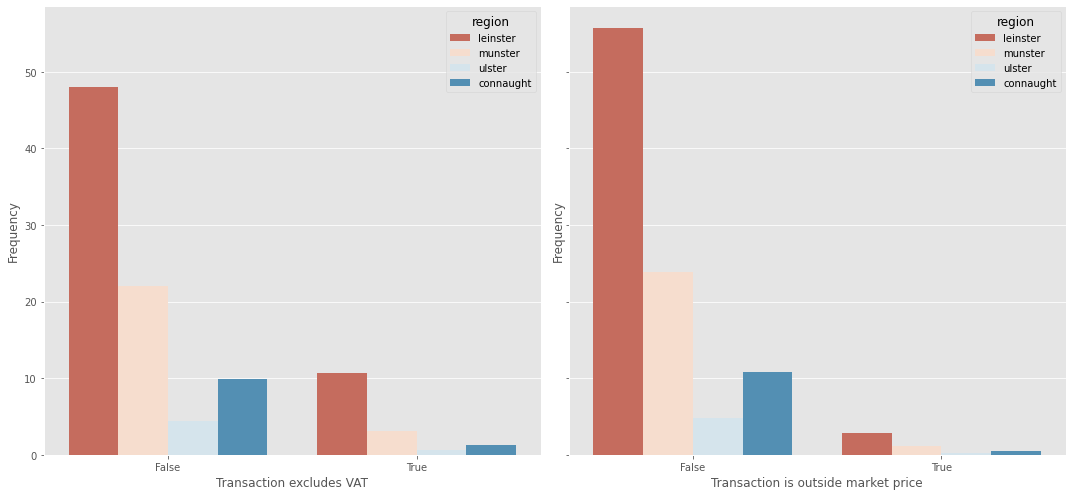

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 7), sharey=True)

# we use barplot with a trick to estimate frequency of the data to plot the % of transactions in the two categories
ax1 = sns.barplot(x="vat_exclusive", 
            y = 'vat_exclusive', 
            hue = 'region', 
            data=df,
            palette='RdBu',
            estimator=lambda x: len(x) / len(df) * 100, 
                 ax = ax1)

ax2 = sns.barplot(x="not_full_market_price", 
            y = 'not_full_market_price', 
            hue = 'region', 
            data=df,
            palette='RdBu',
                  ax = ax2,
            estimator=lambda x: len(x) / len(df) * 100)
ax2.set_xlabel('Transaction is outside market price')
ax2.set_ylabel('Frequency')
ax1.set_xlabel('Transaction excludes VAT')
ax1.set_ylabel('Frequency')


plt.tight_layout()

Most transactions exclude VAT. This could be an indication that these transaction are occurring on new (or renewed property [[1]]).

[1]: https://www2.deloitte.com/ie/en/pages/tax/articles/vat-property-sales.html

It could be interesting to explore how the prices varied over time by regions. We can plot the time series with a measure of variance, like standard deviation, to evaluate the performance of the sale prices over the course of the years. To make time series visualization easier, we can generate an additional dataframe to contain the date and aggregation. 

In order to do that, I think the easiest way is to generate one table for each county we have information on. It can make our life easier to generate all the aggregation on a time basis. I discovered a trick (yes, still learning) that is easy to generate dataframe dynamically using dictionaries and for loops!

In [18]:
county_ls = list(df['county'].unique())

d = {}
ts_df = pd.DataFrame()
ts_df_stack = pd.DataFrame()

for i, val in enumerate(county_ls):
    if i <= len(county_ls):
        d[val] = pd.DataFrame()
        d[val] = df[df['county'] == val][['month_year', 'price', 'region']]
   

ts_df = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()},
                       orient='index')

for i, val in enumerate(county_ls):
    if i <= len(county_ls):
        ts_df_stack['county'] = val
        ts_df_stack.append(ts_df.transpose()[val].dropna())

/Users/manfredimiraula/.virtualenvs/ds/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [19]:
# dublin = ts_df.transpose()['dublin'].dropna()
ts_df_stack.head()

,county


In [ ]:
sns.lineplot(
    x = ts_df.index, 
    y = 'price', 
    hue = 'region', 
    data = ts_df
)


